In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

[ Info: Precompiling GRIJuliaExt [84369c5d-ffb2-5a92-8288-3470980d96d0] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2))


In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
tspan = (0.0f0, 10.0f0)
dt= 0.01f0

0.01f0

In [5]:
using SciMLSensitivity

In [6]:
solver_args = Dict(:adaptive => false,
                :dense => false,
                :dt => dt,
                :sensealg => InterpolatingAdjoint(; autojacvec=ZygoteVJP(allow_nothing=false)), 
                :saveat => tspan[1]:dt:tspan[2])

Dict{Symbol, Any} with 5 entries:
  :saveat   => 0.0f0:0.01f0:10.0f0
  :adaptive => false
  :sensealg => InterpolatingAdjoint{0, true, Val{:central}, ZygoteVJP}(ZygoteVJ…
  :dt       => 0.01
  :dense    => false

In [7]:
spk_args = SpikingArgs(threshold = 0.001f0,
                    steepness = 1000.0f0,
                    solver=Heun(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [8]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [9]:
args = Args(batchsize = 128, epochs = 25, use_cuda = true)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [11]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [12]:
train_loader = DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [14]:
struct OneHotTestLoader
    loader::DataLoader
    n_classes::Int
end

function Base.iterate(loader::OneHotTestLoader)
    state = iterate(loader.loader)
    state === nothing && return nothing
    (x, y), loader_state = state
    y_onehot = onehotbatch(y, 0:(loader.n_classes-1))
    return (x, y_onehot), loader_state
end

function Base.iterate(loader::OneHotTestLoader, loader_state)
    state = iterate(loader.loader, loader_state)
    state === nothing && return nothing
    (x, y), loader_state = state
    y_onehot = onehotbatch(y, 0:(loader.n_classes-1))
    return (x, y_onehot), loader_state
end

Base.length(loader::OneHotTestLoader) = length(loader.loader)

train_loader_onehot = OneHotTestLoader(train_loader, 10)
test_loader_onehot = OneHotTestLoader(test_loader, 10)

OneHotTestLoader(DataLoader(::FashionMNIST, batchsize=128), 10)

In [15]:
x0, y0 = first(train_loader_onehot)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 1 0 … 0 0])

In [16]:
import .PhasorNetworks: phase_to_current, arc_gaussian_kernel

In [17]:
using Zygote: ignore_derivatives

In [18]:
image_to_current = x -> phase_to_current(reshape(x, (28^2, args.batchsize)), spk_args=spk_args, tspan=(0.0f0, 10.0f0))

#1 (generic function with 1 method)

In [19]:
xt = image_to_current(x0)

CurrentCall(LocalCurrent(Main.PhasorNetworks.var"#inner#50"{SpikingArgs, Float32, Nothing, Float32, Matrix{Float32}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 0.0f0, nothing, 0.0f0, Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), (784, 128), 0.0f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 10.0f0))

In [20]:
islice = stack([xt(Float32(ts)) for ts in 0.0:0.01:1.5]);

In [21]:
size(islice)

(784, 128, 151)

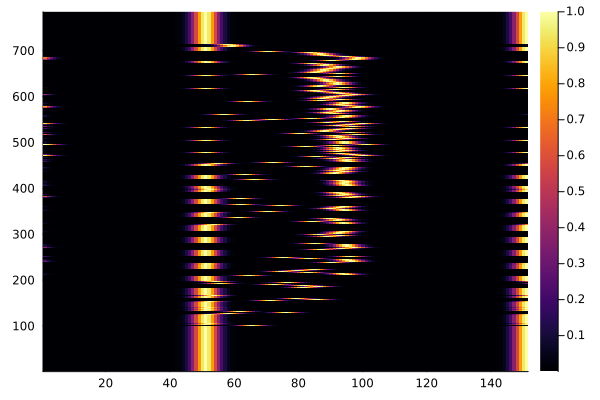

In [22]:
heatmap(islice[:,1,:])

In [23]:
typeof(islice)

Array{Float32, 3}

In [24]:
network = Chain(image_to_current,
    PhasorDense(784 => 128, soft_angle, return_type=PhaseSolution),)

Chain(
    layer_1 = WrappedFunction(#1),
    layer_2 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
)         # Total: 100_608 parameters,
          #        plus 0 states.

In [25]:
ps, st = Lux.setup(args.rng, network)

((layer_1 = NamedTuple(), layer_2 = (layer = (weight = Float32[-0.0056312787 0.04889111 … -0.05050768 0.045184698; -0.040384673 0.033313625 … 0.04332045 -0.045717828; … ; 0.044033002 -0.055932578 … -0.007478507 -0.046164002; 0.024524597 -0.038179252 … 0.0029826495 0.0011508339],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))), (layer_1 = NamedTuple(), layer_2 = (layer = NamedTuple(), bias = NamedTuple(), leakage = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], period = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])))

In [26]:
aa, _ = network(x0, ps, st)

(Float32[0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264; … ; 0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264;;; -0.04383751 0.00044299068 … -0.043731447 0.00025766445; 0.00041384716 0.00039900944 … 0.0004428916 0.00030768756; … ; -0.04561309 -0.044997476 … 0.00041743304 0.00025072848; -0.043017413 -0.044705637 … 0.00043168606 0.029683063;;; -0.04435032 0.00093208125 … -0.04392474 0.00046497243; 0.0008641392 0.0008099386 … 0.00086364703 0.00060870766; … ; -0.047451876 -0.046395343 … 0.00083142205 0.00046276752; -0.04300945 -0.046247687 … 0.0009012686 0.001755413;;; … ;;; -0.39758042 -0.11011293 … 0.88901854 -0.14546642; 0.37187764 0.0008697591 … 0.0682892 -0.11010931; … ; -0.4383037 -0.20244506 … 0.8028251 -0.1477995; 0.9528936 -0.09525799 … -0.5427585 0.96481854;;; -0.39883393 -0.10953695 … 0.89135265 -0.1452276; 0.36735788 0.0007422439 … 0.0681787 -0.11005626; … ; -0.44206786 -0.

In [27]:
size(aa)

(128, 128, 1001)

In [28]:
network2 = Chain(image_to_current,
    PhasorDense(784 => 128, soft_angle, return_type=PhaseSolution),
    PhasorDense(128 => 10, soft_angle, return_type=PhaseSolution),)

Chain(
    layer_1 = WrappedFunction(#1),
    layer_2 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_3 = PhasorDense(
        layer = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),                # 20 parameters
    ),
)         # Total: 101_908 parameters,
          #        plus 0 states.

In [29]:
ps2, st2 = Lux.setup(args.rng, network2)

((layer_1 = NamedTuple(), layer_2 = (layer = (weight = Float32[0.039607193 0.01944627 … 0.00022751502 -0.057039727; -0.009618023 -0.024282424 … 0.009979601 0.02718339; … ; 0.03448291 -0.053464845 … 0.034305 0.045881137; -0.023469754 -0.056783054 … -0.0009875257 0.022305306],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_3 = (layer = (weight = Float32[0.113127045 -0.04885875 … -0.03762582 0.08072976; 0.016276116 -0.043997686 … 0.0995841 0.017578097; … ; -0.09091437 -0.020437691 … -0.024808904 0.018207107; 0.0711904 -0.122683704 … -0.13283393 -0.019145327],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))), (layer_1 = NamedTuple(), layer_2 = (layer = NamedTuple(), bias 

In [30]:
y, _ = network2(x0, ps2, st2)

(Float32[-0.0008799511 -0.0008799511 … -0.0008799511 -0.0008799511; 0.030121572 0.030121572 … 0.030121572 0.030121572; … ; -0.027769336 -0.027769336 … -0.027769336 -0.027769336; -0.008959738 -0.008959738 … -0.008959738 -0.008959738;;; 0.015517006 0.006508262 … 0.0010383108 0.008279462; -0.020681424 -0.016302418 … -0.0068280557 -0.01517688; … ; 0.053600915 -0.05831665 … 0.012459081 -0.014321095; 0.03235397 -0.014603578 … 0.00052947644 -0.03793858;;; -0.008285032 0.01046102 … -0.0025847333 0.001188699; -0.016734364 -0.015447986 … -0.010314415 -0.011059678; … ; 0.0062450576 -0.042437352 … 0.009175298 -0.032331534; 0.025966363 -0.017795281 … 0.006906179 -0.04170653;;; … ;;; -0.15913749 -0.007324295 … 0.053386025 -0.10324733; -0.14543347 -0.09915442 … 0.06417356 -0.18495293; … ; 0.009920811 0.066093005 … 0.017978586 -0.018401604; 0.16386853 0.14471935 … 0.15229309 0.11852631;;; -0.15673128 -0.00661278 … 0.053573098 -0.10303334; -0.14439008 -0.09884229 … 0.0629959 -0.18477693; … ; 0.01077422

In [31]:
size(y)

(10, 128, 1001)

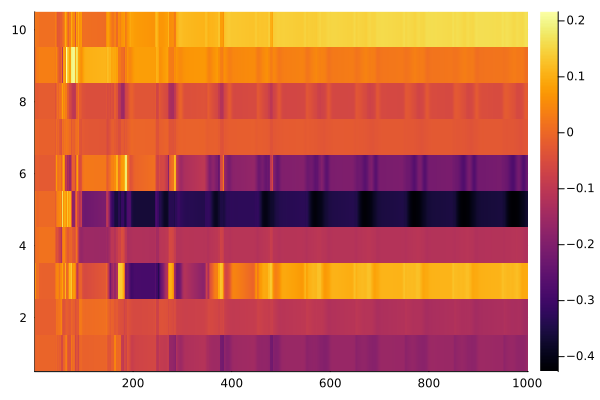

In [32]:
heatmap(y[:,1,:])

In [33]:
y0 |> size

(10, 128)

In [34]:
evaluate_loss(y[:,:,end], y0, :similarity) |> mean

1.0668325715203495

In [35]:
loss_fn = p -> mean(evaluate_loss(network2(x0, p, st2)[1][:,:,end], y0, :similarity))

#5 (generic function with 1 method)

In [36]:
loss_fn(ps2)

1.0668325715203495

In [37]:
pa = ComponentArray(ps2)

ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (layer = (weight = Float32[0.039607193 0.01944627 … 0.00022751502 -0.057039727; -0.009618023 -0.024282424 … 0.009979601 0.02718339; … ; 0.03448291 -0.053464845 … 0.034305 0.045881137; -0.023469754 -0.056783054 … -0.0009875257 0.022305306]), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_3 = (layer = (weight = Float32[0.113127045 -0.04885875 … -0.03762582 0.08072976; 0.016276116 -0.043997686 … 0.0995841 0.017578097; … ; -0.09091437 -0.020437691 … -0.024808904 0.018207107; 0.0711904 -0.122683704 … -0.13283393 -0.019145327]), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])))

In [38]:
spk_args.solver_args

Dict{Symbol, Any} with 5 entries:
  :saveat   => 0.0f0:0.01f0:10.0f0
  :adaptive => false
  :sensealg => InterpolatingAdjoint{0, true, Val{:central}, ZygoteVJP}(ZygoteVJ…
  :dt       => 0.01
  :dense    => false

In [39]:
withgradient(loss_fn, pa)

(val = 1.0668325715203495, grad = ((layer_1 = Float32[], layer_2 = (layer = (weight = Float32[-0.0003695055 -0.0003695055 … -0.0003695055 -0.0003695055; 0.00066328415 0.00066328415 … 0.00066328415 0.00066328415; … ; -0.0009843083 -0.0009843083 … -0.0009843083 -0.0009843083; -0.0023086178 -0.0023086178 … -0.0023086178 -0.0023086178]), bias = (bias_real = Float32[-0.00018411031, 0.00033244473, -0.002159541, -0.0023386742, 0.00087562646, 0.0018044517, -0.0011170069, 0.0016551857, 0.0001856447, -0.00119226  …  -0.0006533929, -0.0017766017, 0.0034301158, -0.0027103608, 0.00061213376, 0.0008028396, -0.0033487342, 0.00035880058, -0.00050363794, -0.0011642254], bias_imag = Float32[-0.002785306, 0.0024633242, 0.0069487737, -0.0009211716, 0.0025611098, 0.00044537263, 0.0031513309, 0.005903618, -0.0012433648, -0.0034376215  …  0.004126781, -0.0054539694, 0.0024791164, -0.004397419, -0.005036873, -0.0055524516, -0.006883669, -0.0001458296, 0.0096911, 0.000660531])), layer_3 = (layer = (weight = Fl

In [40]:
spk_args.t_period

1.0f0

In [41]:
spk_args.t_window

0.01f0

In [56]:
glorot_normal_plusone = (x, z) -> glorot_normal(x, Float32, z...) .+ ones(Float32, z)

#11 (generic function with 1 method)

In [62]:
network3 = Chain(image_to_current,
    PhasorDense(784 => 128, soft_angle, return_type=PhaseSolution, trainable_period=true, init_period = glorot_normal_plusone),
    PhasorDense(128 => 10, soft_angle, return_type=PhaseSolution),)

Chain(
    layer_1 = WrappedFunction(#1),
    layer_2 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_3 = PhasorDense(
        layer = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),                # 20 parameters
    ),
)         # Total: 101_908 parameters,
          #        plus 0 states.

In [63]:
ps3, st3 = Lux.setup(args.rng, network3)

((layer_1 = NamedTuple(), layer_2 = (layer = (weight = Float32[-0.023735091 0.0019882438 … 0.042911354 -0.043284018; -0.019975293 -0.018408844 … -0.04787626 -0.023242857; … ; -0.026924282 0.03395068 … -0.032303218 0.05235854; 0.009279675 -0.051390845 … -0.0516837 -0.05417569],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), period = Float32[1.1333275, 0.9965362, 0.8537001, 1.0488794, 0.9954449, 1.0346385, 1.0594454, 0.957042, 1.0249668, 1.114554  …  0.86058486, 0.85425776, 0.95811844, 0.8410679, 0.9044061, 0.8391085, 0.94204235, 0.84588975, 0.87176085, 0.8198]), layer_3 = (layer = (weight = Float32[-0.026024818 -0.048568226 … 0.096414134 0.079186164; 0.08622195 0.028716786 … -0.10835568 0.06840974; … ; 0.014261722 0.15103503 … 0.13112494 0.103430316; -0.053622305 -0.06358337 … 0

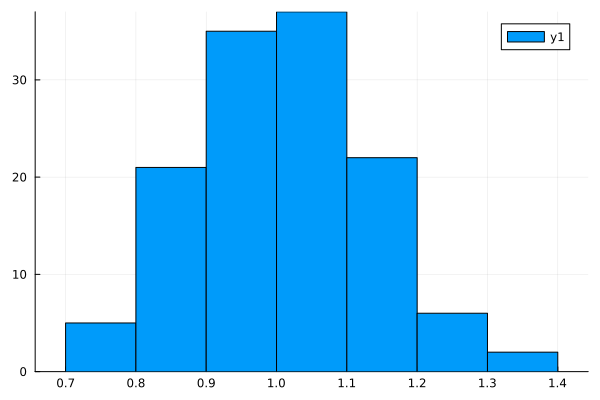

In [68]:
histogram(ps3.layer_2.period)

In [65]:
y, _ = network3(x0, ps3, st3)

(Float32[0.030322503 0.030322503 … 0.030322503 0.030322503; 0.02438784 0.02438784 … 0.02438784 0.02438784; … ; -0.8267161 -0.8267161 … -0.8267161 -0.8267161; 0.020132419 0.020132419 … 0.020132419 0.020132419;;; -0.0107913045 -0.030647121 … -0.022617348 -0.01655909; -0.026141958 -0.00046594426 … -0.009246105 -0.019206718; … ; 0.99559903 0.8414486 … 0.916006 0.94595224; 0.004811226 -0.008371114 … -0.00077335595 -0.00037998136;;; -0.011895956 -0.025852535 … -0.023525042 -0.020028641; -0.023322092 0.0025153495 … -0.01474779 -0.023069793; … ; 0.9786281 0.82410896 … 0.92247075 0.90824074; -0.0009121575 -0.0070667067 … 0.003352804 -0.004138604;;; … ;;; 0.07234507 0.13613017 … 0.054164443 0.065487735; -0.061933197 -0.13769792 … -0.13802786 -0.0071674134; … ; 0.4457159 -0.24611054 … 0.44627416 -0.4488083; -0.009496159 0.121002376 … 0.011503203 0.118784815;;; 0.073113054 0.13542512 … 0.05341402 0.06532748; -0.06304153 -0.13758011 … -0.13885368 -0.007652161; … ; 0.4444251 -0.25492176 … 0.44588172

In [66]:
size(y)

(10, 128, 1001)

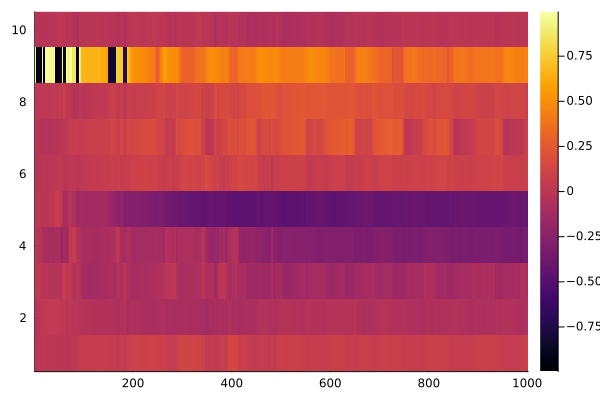

In [67]:
heatmap(y[:,1,:])

In [69]:
evaluate_loss(y[:,:,end], y0, :similarity) |> mean

0.9059360814231302

In [70]:
loss_fn = p -> mean(evaluate_loss(network3(x0, p, st3)[1][:,:,end], y0, :similarity))

#13 (generic function with 1 method)

In [71]:
loss_fn(ps3)

0.9059360814231302

In [72]:
pa3 = ComponentArray(ps3)

ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (layer = (weight = Float32[-0.023735091 0.0019882438 … 0.042911354 -0.043284018; -0.019975293 -0.018408844 … -0.04787626 -0.023242857; … ; -0.026924282 0.03395068 … -0.032303218 0.05235854; 0.009279675 -0.051390845 … -0.0516837 -0.05417569]), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), period = Float32[1.1333275, 0.9965362, 0.8537001, 1.0488794, 0.9954449, 1.0346385, 1.0594454, 0.957042, 1.0249668, 1.114554  …  0.86058486, 0.85425776, 0.95811844, 0.8410679, 0.9044061, 0.8391085, 0.94204235, 0.84588975, 0.87176085, 0.8198]), layer_3 = (layer = (weight = Float32[-0.026024818 -0.048568226 … 0.096414134 0.079186164; 0.08622195 0.028716786 … -0.10835568 0.06840974; … ; 0.014261722 0.15103503 … 0.13112494 0.103430316; -0.053622

In [ ]:
v, gs = withgradient(loss_fn, pa3)

(val = 0.9059360814231302, grad = ((layer_1 = Float32[], layer_2 = (layer = (weight = Float32[0.0024144193 0.0024144193 … 0.0024144193 0.0024144193; 0.00012899529 0.00012899529 … 0.00012899529 0.00012899529; … ; -0.0011234754 -0.0011234754 … -0.0011234754 -0.0011234754; -0.00032528254 -0.00032528254 … -0.00032528254 -0.00032528254]), bias = (bias_real = Float32[0.0012112698, 6.7152396f-5, 0.00013201243, -0.00086594303, 0.0005246244, -0.00017677387, 0.00029759918, -0.0009801863, -0.00035466073, -0.00045497253  …  0.00042013914, -0.00023277436, 0.0005249531, 0.00061790936, 0.00042620377, -0.00010764921, 0.00036882245, 0.00011873451, -0.0005684393, -0.00016666861], bias_imag = Float32[0.0032586036, -0.0027538738, -0.0018665963, -0.0013499989, -0.0018728379, 0.0011166956, -0.0007573346, -0.000106479856, 0.00074423786, -0.0011749284  …  -0.0005236115, 0.00060947647, 0.0010364257, 0.00075630104, 0.0012589463, 8.077588f-5, -0.0012699156, 0.0009784013, -6.4998756f-5, 0.0022410566]), period = F

In [78]:
gs[1].layer_2.period

128-element view(::Vector{Float32}, 100609:100736) with eltype Float32:
 -0.0097102085
 -0.052071035
 -0.02925588
  0.05086801
 -0.14580332
  0.078449234
  0.00709456
 -0.00656864
  0.10100289
  0.01286379
 -0.003945045
  0.10792375
 -0.013844186
  ⋮
  0.04558791
 -0.0005488294
 -0.016001515
  0.01084636
  0.030216513
  0.046162773
  0.021724634
  0.000667942
 -0.019766128
 -0.015941989
 -0.00064487493
  0.0014919358